[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/KMeansClustering.ipynb)

# K-Means clustering
K-means clustering partitions $N$ data-points  into $K$ clusters such that any point is assigned to the cluster with the closest center (*prototype*). The center of each cluster $\mu_k$ is the point minimizing the square of Euclidean distance to every point in the cluster (i.e., the within cluster variance), so the *cost function* is 
$$
J(\{r_{n,k}\},\{\mu_k\}) = \sum_{n=1}^N \sum_{k=1}^K r_{n,k} || x^{(n)} - \mu_k||^2_2 \quad \text{s.t.} \quad \sum_k r_{n,k} = 1,\; r_{n,k} \in {0,1}
$$
 where $r_{n,k}=1$ if the point $n$ is assigned to cluster $k$ and zero otherwise. 
 This is a difficult optimization problem. 
 Our strategy is to start from some assignment to *iteratively optimize $J$* each time keeping either the center or the memberships fixed.
- fixed centers: minimizing $J$ assigns each point to the closest center x
- fixed membership: minimizing $J$ finds the mean of cluster centers. To see why set the derivative of $J$ wrt $\mu_k$ to zero and solve
$$
\frac{\partial}{\partial \mu_k} \sum_n r_{n,k} || x^{(n)} - \mu_k||_2^2 = 2 \sum_n r_{n,k} (x^{(n)} - \mu_k) = 0 \Rightarrow \mu_k = \frac{\sum_n r_{n,k} x^{(n)}}{\sum_n r_{n,k}}
$$

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
class KMeans:
    def __init__(self, k=5, max_iters=100, verbose=True):
        """
        Initialize K-Means clustering model.
        
        Parameters:
        k: number of clusters to form
        max_iters: maximum number of iterations for the EM algorithm
        verbose: if True, print convergence information
        """
        self.k = k                                            # number of cluster centers
        self.max_iters = max_iters
        self.verbose = verbose                                # we generally use this to print something inside a class or function
    
    def fit(self, x):
        """
        Fit K-Means clustering model using the Expectation-Maximization algorithm.
        
        The algorithm alternates between:
        1. E-step: Assign each point to the nearest cluster center (expectation)
        2. M-step: Update cluster centers as the mean of assigned points (maximization)
        
        Parameters:
        x: input data, shape (N, D) where N=samples, D=features
        
        Returns:
        mu: cluster centers, shape (K, D)
        membership: cluster assignment for each point, shape (N,)
        """
        n, d = x.shape  # n = number of samples, d = number of features
        
        # Initialize cluster centers by randomly selecting K distinct data points
        # np.random.choice(n, self.k, replace=False) generates K unique indices from [0, n-1]
        # replace=False ensures we don't pick the same point twice
        init_centers = np.random.choice(n, self.k, replace=False)
        
        # mu stores the K cluster centers, shape (K, D)
        # Each row mu[k] is the center of cluster k
        mu = x[init_centers]
        
        # Main K-Means loop: alternate between assignment and update steps
        for t in range(self.max_iters):
            
            # === E-STEP: Assign each point to nearest cluster center ===
            
            # Compute squared Euclidean distance from each point to each center
            # Advanced indexing: mu[None,:,:] has shape (1, K, D)
            #                    x[:,None,:] has shape (N, 1, D)
            # Broadcasting: (1, K, D) - (N, 1, D) -> (N, K, D)
            # Result: distances[i, j, :] = mu[j, :] - x[i, :]
            # This computes all pairwise differences in one operation
            diff = mu[None, :, :] - x[:, None, :]  # shape (N, K, D)
            
            # Square each element and sum along the feature dimension (axis=-1)
            # distances[i, j] = ||x[i] - mu[j]||^2
            # Shape: (N, K) where distances[i, j] = squared distance from point i to center j
            distances = np.sum(diff**2, -1)
            
            # Find the closest cluster center for each point
            # argmin along axis=1 finds the cluster index with minimum distance
            # membership[i] = k means point i is assigned to cluster k
            # Shape: (N,) - one cluster assignment per point
            membership = np.argmin(distances, axis=1)
            
            # === M-STEP: Update cluster centers ===
            
            # Create a copy to compare for convergence
            mu_new = mu.copy()
            
            # Update each cluster center to be the mean of its assigned points
            for i in range(self.k):
                # membership == i creates a boolean mask: shape (N,)
                # True where points belong to cluster i, False otherwise
                # x[membership == i] selects only points in cluster i
                # Result shape: (num_points_in_cluster_i, D)
                
                # np.mean(..., axis=0) computes the mean along the samples axis
                # This gives the centroid of cluster i: shape (D,)
                mu_new[i, :] = np.mean(x[membership == i], axis=0)
            
            # === Check for convergence ===
            
            # np.allclose checks if mu_new and mu are element-wise equal (within tolerance)
            # If cluster centers don't change, the algorithm has converged
            if np.allclose(mu_new, mu):
                if self.verbose:
                    # Compute final cost (within-cluster sum of squared distances)
                    # np.min(distances, 1) finds the distance to the nearest center for each point
                    # Sum over all points to get total cost
                    final_cost = np.sum(np.min(distances, 1))
                    print(f'converged after {t} iterations, cost {final_cost}')
                break
            
            # Update cluster centers for next iteration
            mu = mu_new
        
        return mu, membership

There's a problem with this implementaion, can you find it? (what if a center receives no members at all?) can you suggest a fix?

Let's cluster the Iris dataset into 3 clusters (only using 2 features for better visualization)

converged after 5 iterations, cost 37.05070212765958


Text(0.5, 1.0, 'class labels')

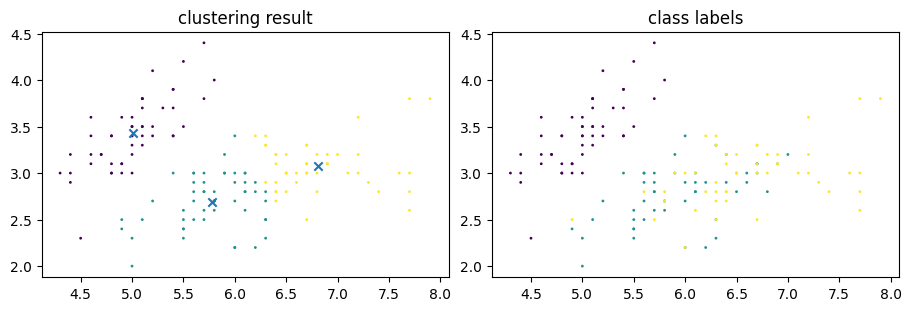

In [3]:
from sklearn import datasets

# Load the famous Iris dataset
# Contains 150 samples of iris flowers with 4 features each
dataset = datasets.load_iris()

# Extract only the first 2 features for 2D visualization
# dataset['data'] has shape (150, 4), we take only columns 0 and 1 (sepal length and width)
# dataset['target'] contains true class labels: 0, 1, or 2 (three species of iris)
x, y = dataset['data'][:, :2], dataset['target']

# Fit K-Means with K=3 clusters (matching the 3 true classes)
kmeans = KMeans(3)
mu, cl = kmeans.fit(x)

# Plotting the clustering result vs. true class labels
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3))

# Left plot: K-Means clustering result
# Color points by their cluster assignment (cl)
# x[:, 0] is first feature (sepal length), x[:, 1] is second feature (sepal width)
axes[0].scatter(x[:, 0], x[:, 1], c=cl, s=1)

# Plot cluster centers as 'x' markers
# mu[:, 0] and mu[:, 1] are the coordinates of the K cluster centers
axes[0].scatter(mu[:, 0], mu[:, 1], marker='x')
axes[0].set_title('clustering result')

# Right plot: True class labels for comparison
# Color points by their true class (y)
axes[1].scatter(x[:, 0], x[:, 1], c=y, s=1)
axes[1].set_title('class labels')

There are a variety of solutions for
- choosing $K$
- initializing the cluster centers
- optimizing the cost function above
- improving the time complexity

## Vector Quantization
One of the original applications of K-means is in vector quantization. For example, given an image, K-means enables compression by treating each pixel as a data-point and replacing its value with tht of cluster center. For this example we will use scikit-learn's implementation as it uses `kmeans++` initialization, it does repeated runs and reports the best results, and it is much faster.

(427, 640, 3)


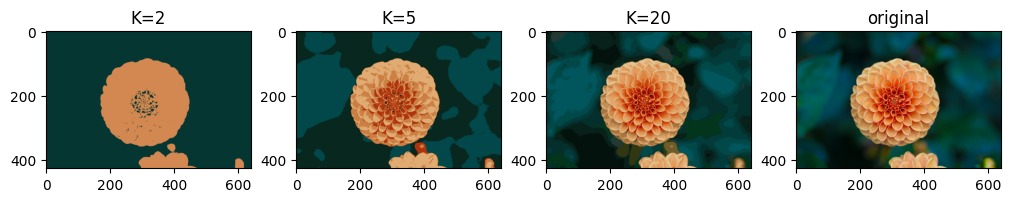

In [4]:
from sklearn.datasets import load_sample_images
import sklearn.cluster

# Load sample images from scikit-learn
dataset = load_sample_images()

# Select the second image (index 1)
# Shape is (height, width, 3) where 3 represents RGB color channels
x = dataset.images[1]
print(x.shape)  # note that each pixel is a vector of size 3 (RGB values)

# Different values of K (number of colors in compressed image)
kvals = [2, 5, 20]

# Create subplots: one for each K value plus the original
fig, axes = plt.subplots(ncols=len(kvals)+1, nrows=1, constrained_layout=True, figsize=(10, 3))

for i, k in enumerate(kvals):
    # Fit K-Means with k clusters
    # n_clusters=k means we'll represent the image using only k colors
    kmeans = sklearn.cluster.KMeans(n_clusters=k)
    
    # Reshape image from (height, width, 3) to (height*width, 3)
    # np.reshape(x, [-1, 3]) treats each pixel as a 3D point (R, G, B)
    # -1 means "infer this dimension" -> height * width
    # Shape: (num_pixels, 3) where num_pixels = height * width
    kmeans = kmeans.fit(np.reshape(x, [-1, 3]))
    
    # kmeans.labels_ contains cluster assignment for each pixel, shape (num_pixels,)
    # kmeans.cluster_centers_ contains the k RGB values (cluster centers), shape (k, 3)
    
    # Replace each pixel's RGB value with its cluster center's RGB value
    # kmeans.labels_ is array of indices [0, k-1], shape (num_pixels,)
    # kmeans.cluster_centers_[kmeans.labels_, :] selects the cluster center for each pixel
    # Advanced indexing: for each pixel, retrieve its cluster center's RGB value
    # Result shape: (num_pixels, 3)
    x_rec = np.round(kmeans.cluster_centers_[kmeans.labels_, :]).astype(int)
    
    # Reshape back to original image dimensions
    # (num_pixels, 3) -> (height, width, 3)
    x_rec = np.reshape(x_rec, x.shape)
    
    # Display the compressed image
    axes[i].imshow(x_rec)
    axes[i].set_title(f'K={k}')

# Display original image in the last subplot
axes[-1].imshow(x)
axes[-1].set_title('original')

# Note: This line is redundant (already shown in the subplot)
plt.imshow(x)

# K-Medoid clustering
What if our features are not continuous? what if squared Euclidean distance is not the right distance measure?
For some distance functions $\min_{\mu_k} \sum_n \mathrm{dist}(\mu_k, x^{(n)})$ has a closed form solution (e.g., mean for squared Euclidean or median for Manhattan distance); while for some other distances (e.g., Euclidean distance) no such closed form solution exists. One way around this is to assume cluster centers are subsets of the data points. Assuming we can evaluate the distance, optimization above becomes that of *choosing* a member of the cluster as its representative (medoid):
$\min_{n'} \sum_n \mathrm{dist}(x^{(n')}, x^{(n)})$.

In [5]:
# Define different distance metrics for K-Medoids

# Euclidean distance: sqrt(sum of squared differences)
# x1, x2 can be arrays with shape (..., D) where D is the feature dimension
# Returns: distance array with shape (...)
euclidean = lambda x1, x2: np.sqrt(np.sum((x1-x2)**2, -1))

# Manhattan distance (L1 distance): sum of absolute differences
# Also known as "taxicab distance" or "city block distance"
manhattan = lambda x1, x2: np.sum(np.abs(x1-x2), -1)

# Hamming distance: count of positions where elements differ
# Useful for categorical/binary features
# (x1 != x2) creates boolean array, sum counts the number of True values
hamming = lambda x1, x2: np.sum((x1 != x2), -1)


class KMedoids:
    
    def __init__(self, K=5, max_iters=100, dist_fn=euclidean, repeats=10):
        """
        Initialize K-Medoids clustering model.
        
        Unlike K-Means (which uses mean as cluster center), K-Medoids uses
        an actual data point (medoid) as the cluster representative.
        This makes it more robust to outliers and works with any distance function.
        
        Parameters:
        K: number of clusters to form
        max_iters: maximum iterations per single run
        dist_fn: distance function to use (euclidean, manhattan, hamming, etc.)
        repeats: number of random restarts (helps avoid local minima)
        """
        self.K = K
        self.max_iters = max_iters                        # for computing each medoid
        self.dist_fn = dist_fn
        self.repeats = repeats                            # for several runs to compute medoids
    
    def fit(self, x):
        """
        Fit K-Medoids clustering model.
        
        The algorithm iteratively:
        1. Assigns each point to the nearest medoid
        2. For each cluster, selects the point that minimizes total distance
           to other points in the cluster as the new medoid
        
        Parameters:
        x: input data, shape (N, D) where N=samples, D=features
        
        Returns:
        best_medoids: indices of the K medoid points, shape (K,)
        best_membership: cluster assignment for each point, shape (N,)
        """
        # Note that medoids stores a list of K indices (not coordinates like K-Means)
        n, d = x.shape
        
        # Compute all pairwise distances upfront (memoization for efficiency)
        # Advanced indexing: x[None, :, :] has shape (1, N, D)
        #                    x[:, None, :] has shape (N, 1, D)
        # Broadcasting: (1, N, D) and (N, 1, D) -> (N, N, D)
        # Result: distances[i, j] = distance from point i to point j
        # Shape: (N, N) - symmetric distance matrix
        distances = self.dist_fn(x[None, :, :], x[:, None, :])
        
        best_cost = np.inf
        
        # Try multiple random initializations to avoid local minima
        for r in range(self.repeats):
            # Randomly choose K distinct data points as initial medoids
            # medoids is an array of K indices into the data
            medoids = np.random.choice(n, self.K, replace=False)
            
            # Iteratively refine medoids
            for t in range(self.max_iters):
                
                # === E-STEP: Assign each point to nearest medoid ===
                
                # distances[medoids, :] selects K rows from the distance matrix
                # Advanced indexing: medoids is shape (K,), so result is shape (K, N)
                # distances[medoids, :][k, i] = distance from medoid k to point i
                
                # argmin along axis=0 finds which medoid is closest for each point
                # membership[i] = k means point i is assigned to medoid k
                # Shape: (N,) - one cluster assignment per point
                membership = np.argmin(distances[medoids, :], axis=0)
                
                # === M-STEP: Update medoids ===
                
                new_medoids = medoids.copy()
                cost = 0
                
                # For each cluster, find the best medoid (point minimizing within-cluster distance)
                for i in range(self.K):
                    
                    # Find indices of all points in cluster i
                    # np.nonzero(membership == i) returns a tuple, [0] extracts the array
                    # cluster_inds contains indices of points belonging to cluster i
                    # Shape: (num_points_in_cluster_i,)
                    cluster_inds = np.nonzero(membership == i)[0]
                    
                    # Extract the submatrix of pairwise distances within this cluster
                    # np.ix_ creates index arrays for advanced indexing
                    # distances[np.ix_(cluster_inds, cluster_inds)] is shape (num_points, num_points)
                    # This gives distances between all pairs of points in cluster i
                    
                    # Sum along axis=1 to get total distance from each point to all others in cluster
                    # cluster_dist[j] = sum of distances from point j to all other points in cluster
                    # Shape: (num_points_in_cluster_i,)
                    cluster_dist = np.sum(distances[np.ix_(cluster_inds, cluster_inds)], axis=1)
                    
                    # Add the minimum total distance to the cost
                    # This is the cost contribution of cluster i
                    cost += np.min(cluster_dist)
                    
                    # Select the point with minimum total distance as the new medoid
                    # np.argmin(cluster_dist) gives the index within the cluster
                    # cluster_inds[...] converts it to the global index
                    new_medoids[i] = cluster_inds[np.argmin(cluster_dist)]
                
                # Check for convergence: if medoids don't change, we're done
                if np.allclose(new_medoids, medoids):
                    # print(f'converged after {t} iterations with the cost {cost}')
                    break
                
                medoids = new_medoids
            
            # Keep track of the best solution across all random restarts
            if cost < best_cost:
                best_medoids = medoids
                best_membership = membership
        
        return best_medoids, best_membership

Let's find K **representative samples** from the `MNIST` dataset.

In [6]:
from sklearn.datasets import fetch_openml

# Load the MNIST dataset (handwritten digits 0-9)
# x_org has shape (70000, 784) - 70000 images, each flattened to 784 pixels (28x28)
# y contains the digit labels (0-9)
x_org, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [7]:
# Use only first 1000 samples for faster computation
# x has shape (1000, 784)
x = x_org[:1000, ...]

# Fit K-Medoids with K=10 (one representative per digit class)
# repeats=1000 means we try 1000 random initializations to find the best medoids
kmedoid = KMedoids(10, repeats=1000)

# Find 10 medoids (actual data points that best represent the 10 digit classes)
# centers contains the indices of the 10 medoid images, shape (10,)
# _ ignores the membership assignments (we only care about the medoids here)
centers, _ = kmedoid.fit(x.reshape(-1, 784))

from mpl_toolkits.axes_grid1 import ImageGrid

def plot_digits(data):
    """
    Plot a row of digit images.
    
    Parameters:
    data: array of flattened images, shape (num_images, 784)
    """
    num_plots = data.shape[0]
    
    # Create a figure with multiple subplots arranged horizontally
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    
    # ImageGrid creates a grid of axes for displaying images
    # nrows_ncols=(1, num_plots) means 1 row, num_plots columns
    # axes_pad=0.1 is the padding between images
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    
    for i in range(num_plots):
        # Reshape flat vector (784,) back to 2D image (28, 28)
        # Display the image in grayscale
        grid[i].imshow(data[i].reshape((28, 28)))
    
    plt.show()

# Plot the 10 representative digits (medoids)
# x[centers] uses advanced indexing to select the medoid images
# Shape: (10, 784) - the 10 images that best represent each digit cluster
plot_digits(x[centers])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(slice(None, 1000, None), Ellipsis)' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/siamak/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q5/s9mf5l893mq7px27cd0zfs9w0000gn/T/ipykernel_85780/1177542499.py", line 3, in <module>
    x = x_org[:1000, ...]
  File "/opt/homebrew/lib/python3.10/site-packages/pandas/core/frame.py", line 3807, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/opt/homebrew/